In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Importing the dataset
df = pd.read_excel("data/data_polymerization.xlsx")

In [14]:
df.shape

(2708, 21)

In [3]:
# separating features X from target y
X = df.iloc[:, 1:-1]  # starting at column 1 --> no time stamp in data
y = df.iloc[:, -1]

In [5]:
# randomly separate training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [6]:
from sklearn.preprocessing import StandardScaler

# define scaler object
sc = StandardScaler()
# fit scaler based on training data, scale training data
X_train_sc = sc.fit_transform(X_train)
# scale test data
X_test_sc = sc.transform(X_test)

In [7]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from multiprocessing import cpu_count
from scipy.stats import uniform

# define regressor
regressor = RandomForestRegressor(max_samples=0.1)

# hyperparameter definition
tuned_parameters = {
    "ccp_alpha": uniform(loc=0, scale=1),
    "max_features": list(range(3, 20)),
}

# create time split object
ts = TimeSeriesSplit(n_splits=3)
# create cross validation object  --> scoring is MSE
tuner_rf = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=tuned_parameters,
    n_iter=50,
    scoring="neg_mean_squared_error",
    cv=ts,
    n_jobs=cpu_count() - 2,
    return_train_score=True,
    verbose=2,
)

tuner_rf.fit(X_train_sc, y_train)

print(f"best_params: {tuner_rf.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
best_params: {'ccp_alpha': 0.0412094086913396, 'max_features': 10}


In [8]:
from sklearn.tree import DecisionTreeRegressor

# define regressor
regressor = DecisionTreeRegressor()

# hyperparameter definition
tuned_parameters = {
    "ccp_alpha": uniform(loc=0, scale=1),
    "max_features": list(range(3, 20)),
}

# create time split object
ts = TimeSeriesSplit(n_splits=3)
# create cross validation object --> scoring is MSE
tuner_dt = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=tuned_parameters,
    n_iter=50,
    scoring="neg_mean_squared_error",
    cv=ts,
    n_jobs=cpu_count() - 2,
    return_train_score=True,
    verbose=2,
)

tuner_dt.fit(X_train_sc, y_train)

print(f"best_params: {tuner_dt.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
best_params: {'ccp_alpha': 0.002347253020767437, 'max_features': 13}


In [9]:
from sklearn.metrics import root_mean_squared_error

print("Random Forest Results:")
print(
    f"Training RMSE: {root_mean_squared_error(tuner_rf.best_estimator_.predict(X_train_sc), y_train)}"
)
print(
    f"Testing RMSE: {root_mean_squared_error(tuner_rf.best_estimator_.predict(X_test_sc), y_test)}"
)
print("Decision Tree Results:")
print(
    f"Training RMSE: {root_mean_squared_error(tuner_dt.best_estimator_.predict(X_train_sc), y_train)}"
)
print(
    f"Testing RMSE: {root_mean_squared_error(tuner_dt.best_estimator_.predict(X_test_sc), y_test)}"
)

Random Forest Results:
Training RMSE: 2.026234163702119
Testing RMSE: 2.146843620314653
Decision Tree Results:
Training RMSE: 0.5003650715539045
Testing RMSE: 2.84707687363763


In [10]:
# create data frame from tuning restults for plotting
df_rf = pd.DataFrame.from_dict(tuner_rf.cv_results_["params"])
df_rf["mse_test"] = tuner_rf.cv_results_["mean_test_score"] * -1
df_rf["mse_train"] = tuner_rf.cv_results_["mean_train_score"] * -1
df_rf["ccp_alpha"] = np.round(df_rf["ccp_alpha"], decimals=10)

In [11]:
# create data frame from tuning restults for plotting
df_dt = pd.DataFrame.from_dict(tuner_dt.cv_results_["params"])
df_dt["mse_test"] = tuner_dt.cv_results_["mean_test_score"] * -1
df_dt["mse_train"] = tuner_dt.cv_results_["mean_train_score"] * -1
df_dt["ccp_alpha"] = np.round(df_dt["ccp_alpha"], decimals=10)

<Axes: xlabel='ccp_alpha', ylabel='max_features'>

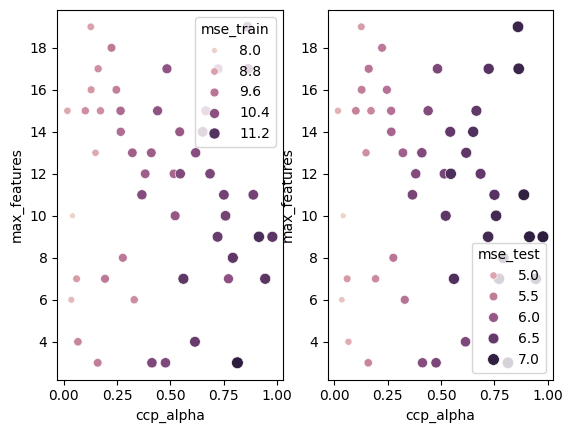

In [12]:
fig, ax = plt.subplots(1,2)

sns.scatterplot(df_rf, x="ccp_alpha", y="max_features", hue="mse_train", size="mse_train", ax=ax[0])
sns.scatterplot(df_rf, x="ccp_alpha", y="max_features", hue="mse_test", size="mse_test", ax=ax[1])

<Axes: xlabel='ccp_alpha', ylabel='max_features'>

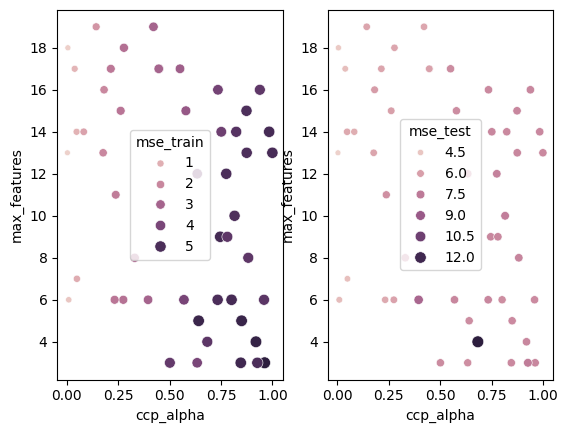

In [13]:
fig, ax = plt.subplots(1,2)

sns.scatterplot(df_dt, x="ccp_alpha", y="max_features", hue="mse_train", size="mse_train", ax=ax[0])
sns.scatterplot(df_dt, x="ccp_alpha", y="max_features", hue="mse_test", size="mse_test", ax=ax[1])